## Benchmarking

In [1]:
from functions import cholesky_tsqr, direct_tsqr

### 1) Changing the number of partitions 

Let's spawn a cluster with 12 workers:

In [ ]:
from dask.distributed import Client, SSHCluster

cluster = SSHCluster(
    ["10.67.22.154", "10.67.22.216", "10.67.22.116", "10.67.22.113"],
    connect_options={"known_hosts": None},
    remote_python="/home/ubuntu/miniconda3/bin/python",
    scheduler_options={"port": 8786, "dashboard_address": ":8797"},
    worker_options={
        "nprocs": 4,        # We spawn 4 processes for each VM (4-core) -> 12 workers
        "nthreads": 1       # We use 1 threads. Following Dask documentation, however, Numpy should release well the GIL lock thus we could use more than 1 thread. 
    }
)

client = Client(cluster)

In [4]:
# Let's see if everything went smoothly
cluster

SSHCluster(SSHCluster, 'tcp://10.67.22.154:8786', workers=12, threads=12, memory=23.25 GiB)

To test our three algorithms (Cholesky, Indirect, Direct), we’ll work with the [HIGGS dataset](https://archive.ics.uci.edu/dataset/280/higgs). This dataset is a great choice because it is large enough to challenge the memory of a standard laptop (making Dask an ideal tool) while still being easy to access from the web. Let’s start by loading it into a`dask.array`.

In [5]:
import dask.dataframe as dd
import os

os.chdir("/home/ubuntu") 
path_HIGGS = os.getcwd() + "/datasets/HIGGS.csv"

df = dd.read_csv(path_HIGGS, header=None, blocksize="200MB")    # The block size can be customized, let's start with 200 MB
X_df = df.iloc[:, 1:] 
X_da = X_df.to_dask_array(lengths=True)   # We want it as a matrix (an array, that is)

At this stage, Dask has analyzed the dataset and set up the partitioning, but the chunks haven’t yet been sent to the workers

In [6]:
#print some info
X_da

dask.array<read-_to_string_dtype-values, shape=(11000000, 28), dtype=float64, chunksize=(275002, 28), chunktype=numpy.ndarray>

Using blocks of $200 , \text{MB}$, Dask divided the array into $40$ chunks. 
Our first goal now is to study how the performance of each algorithm changes (measured as time taken to run the computations) as the number of partitions varies. In this first experiment, we will keep both the number of workers ($12$) and the dataset fixed.

In [7]:
import time
from dask.distributed import wait
import numpy as np

# a function to measure execution time
def benchmark(X_da, algorithm, rep = 20, verbose = False):
    res = [] 
    if (verbose): print("Fun:", algorithm.__name__,", completion status: ", end = "")
    for _ in range(rep):
        if(verbose): print( _, end = " ")
            
        #start a timer
        start = time.time()
        # launch the function, obtain Q and R and persist (we don't want them to be sent to the client)
        Q, R = algorithm(X_da)
        Q = Q.persist()
        R = R.persist()
        wait([Q, R])   # Wait until Q and R are available in the worker's memory. 
        end = time.time()
        res.append(end-start)
        # Remove Q and R from the worker's memory, so that each run is the same
        client.cancel(Q)
        client.cancel(R)
    if(verbose): print()
    return res

In [8]:
n_partitions = [12, 15, 18, 21, 24, 27, 30, 33, 36, 42]
average_time = np.zeros((3, len(n_partitions)))
std_dev_time = np.zeros((3, len(n_partitions)))
for i, part in enumerate(n_partitions):
    print("N. partitions = ", part)
    X_da = X_da.rechunk({0: X_da.shape[0] // part, 1: -1}).persist()    # Repartition X_da and persist (save in the worker's memory)
    wait(X_da)   # Wait until Dask has finished to repartition (we don't want to count the time used to repartition
    t_cholesky = benchmark(X_da, cholesky_tsqr, rep = 20, verbose = True)
    t_direct = benchmark(X_da, direct_tsqr, rep = 20, verbose = True)
    average_time[0,i] = np.mean(t_cholesky)
    std_dev_time[0,i] = np.std(t_cholesky)
    
    average_time[1,i] = np.mean(t_direct)
    std_dev_time[1,i] = np.std(t_direct)

Fun: cholesky_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Fun: direct_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Fun: cholesky_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Fun: direct_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Fun: cholesky_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Fun: direct_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Fun: cholesky_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Fun: direct_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Fun: cholesky_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Fun: direct_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Fun: cholesky_tsqr , completion status: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Fun: dire

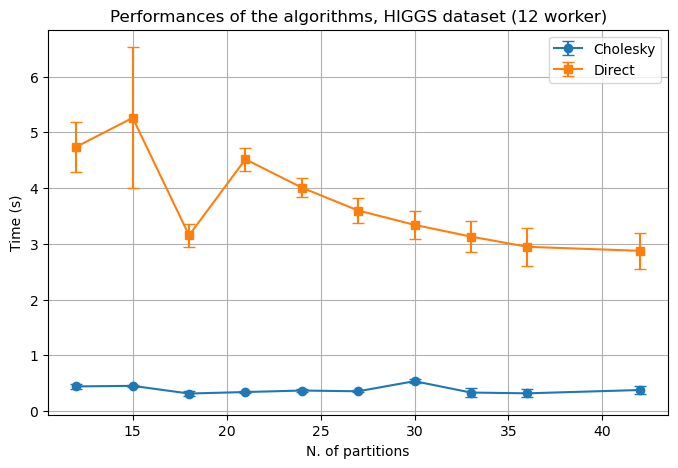

In [9]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.errorbar(n_partitions, average_time[0], yerr=std_dev_time[0,], label="Cholesky", fmt='-o', capsize=4)
plt.errorbar(n_partitions, average_time[1], yerr=std_dev_time[1,], label="Direct", fmt='-s', capsize=4)

plt.xlabel("N. of partitions")
plt.ylabel("Time (s)")
plt.title("Performances of the algorithms, HIGGS dataset (12 worker)")
plt.legend()
plt.grid(True)
plt.show()

As a first observation, we can see that the Cholesky-based decomposition achieves significantly better performance compared to the state-of-the-art direct (and indirect) algorithms. At first glance, this might suggest that Cholesky is the best method for performing QR decomposition on large datasets. However, as already mentioned, the Cholesky approach suffers from severe numerical instability issues when the dataset size grows (as in our case). In fact, …

---

In [51]:
from dask.array.linalg import tsqr
import dask.array as da

Qch, Rch = cholesky_tsqr(X_da)    # Output from Cholesky
Qd, Rd = direct_tsqr(X_da)        # Output from our implementation of Direct method
Qt, Rt = tsqr(X_da)   # Output of official TSQR function in the Dask library

# Now let's trigger the computations
Qch, Rch = Qch.persist(),  Rch.persist()
Qd, Rd = Qd.persist(), Rd.persist()
Qt, Rt = Qt.persist(), Rt.persist()

print("Maximum difference between R_ch and R_dir: ", np.max( np.abs(Rch.T.compute()-Rd.compute()) ))

print("Maximum difference between R_dir and R as computed by the official Dask function: ", np.max(np.abs(Rt.compute()-Rd.compute()) ))

print()

print("Maximum difference between Q_ch and Q_dir: ", np.max(np.abs(Qch - Qd)).compute())
print("Maximum difference between Q_dir and Q as computed by the official Dask function: ", np.max(np.abs(Qt - Qd)).compute())

Maximum difference between R_ch and R_dir:  8378.128683721905
Maximum difference between R_dir and R as computed by the official Dask function:  0.0

Maximum difference between Q_ch and Q_dir:  0.02409022420744581
Maximum difference between Q_dir and Q as computed by the official Dask function:  2.168404344971009e-19


As expected, the results obtained with the Cholesky method are completely unreliable, whereas the Direct method—although it takes more time—achieves the desired precision.

In [64]:
client.close()
cluster.close()